# DT2470 Lab 02: Synchronization and rhythm

*by Group 6: Sergi Andreu and Carsten van de Kamp*

In this lab you will choose to **either** do exercises regarding synchronization (chapter 3), **or** rhythm and tempo processing (chapter 6). We agree that doing both would be too much work (for this year), but you will have the code for the solutions for both anyway!

Again, you can use whatever software you want for your own implementation, but I use python in my explanations, and two external libraries in python need to be used in this Lab. Just as Bob, I am basically learning Python by working on this lab, so excuse my bad programming. (I am a bad programmer independent of language, anyway.)

Your task is to reproduce all shown figures with your code (or show the equivalent plots for your own audio files, if you use different ones). Also, provide short answers to the questions in the text.

## Audio samples:
 
In my examples I use file from the following google folder:

https://drive.google.com/drive/folders/1TGj4ZcEgdGXt9Eko2qViiiKWkUDDewbL?usp=sharing

You can copy these files to your own google folder and use them as explained in Lab 1.

At some points I will ask you to use some audio examples of your own. Be creative...the goal is to check where systems work or fail, and understand (to some extent) those behaviors.

## Code preparations

As for Lab 1, you need to have some external libraries also here:

In [6]:
#other preparations!
# import os, sys
from scipy import signal
import pydub
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Google drive:

you need to adapt the following code to use the audio files that you copied to your google drive.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

# We choose do do part 2: Rhythm and tempo processing

# 2. Rhythm and tempo processing

In this part, we compute a spectral-based novelty function (often called spectral flux) to obtain onsets, we compute a Fourier tempogram to get tempo estimates, and we compare the beat tracker presented in the book with a recent state-of-the-art beat tracker that uses deep learning (out of the box using available code!).

Show your versions of my plots, and provide us with your code, and answer the questions in the text.

## Part 2.1 Onset detection using spectral-based novelty

In the examples below, I use the drumloop120_mono.wav to obtain the plots.

As a first step, compute a short-time Fourier transform (STFT) magnitude spectrogram, by applying a short window (I use 30ms, and 10ms hop size). Use the code from Lab 1 as starting point to read audio files and compute the STFT.

Then apply logarithmic compression (equation 6.5). Then the log-magnitude spectrum looks as follows for me (with gamma=100):

![](https://drive.google.com/uc?id=1F3Y3_iHy6tIZq2guIeQXIQIKPaONTzNO)

The next step is to compute the difference over time, and to do what is referred to as half-wave rectification in the book (equation 6.6). Plot the obtained matrix, which looks for me as follows:

![](https://drive.google.com/uc?id=17LaxEAAliDfaQ72V807iw4y9FkUdV_SK)

As you can see, the impulses of the drum onsets are emphasized in this representation. 

Now you add this matrix along the columns to get a single vector, which looks as the blue line in the plot below.

![](https://drive.google.com/uc?id=1-iC2NFpeOx65vsbhiyk7-sWZ1NSljWde)

The yellow line shows the local average function (equation 6.7, mu(n)) that we will use for post processing. Hint: in order to obtain the local average function in python you can use the numpy function convolve(), if you google for "moving average" and "np.convolve" you will find examples.

When you subtract mu(n) from the spectral flux vector, and keep only positive values (equation 6.8), you obtain the final spectral novelty function. In addition, normalize the obtained vector so that the maximum is 1. It looks as follows for me (the blue line):

![](https://drive.google.com/uc?id=1rCRnhHkc_sR2d-wGIojRbmkOAAJrwmbb)

Finally, we want to obtain onsets! We do this by thresholding the obtained function, which means determining all points at which the function is larger than a certain number. The dotted red lines show the onsets that I get with a threshold of 0.5. (Hint: the stem function from the matplotlib does that plotting for you)

What is the value you need to set for the threshold to detect all onsets? Try it with another sound file, is the value the same?

Do you observe any other problems with the obtained onset detection?



In [7]:
# Getting the audio file (already downloaded)

filepath = 'drive/drumloop120_mono.wav'
sound = pydub.AudioSegment.from_file(filepath, format="wav")

sample_rate = sound.frame_rate
duration    = sound.duration_seconds
samples     = sound.get_array_of_samples()

# Normalizing
samples = np.array(samples) / sound.max_possible_amplitude

Text(0.5, 1.0, 'Soundfile: drive/drumloop120_mono.wav')

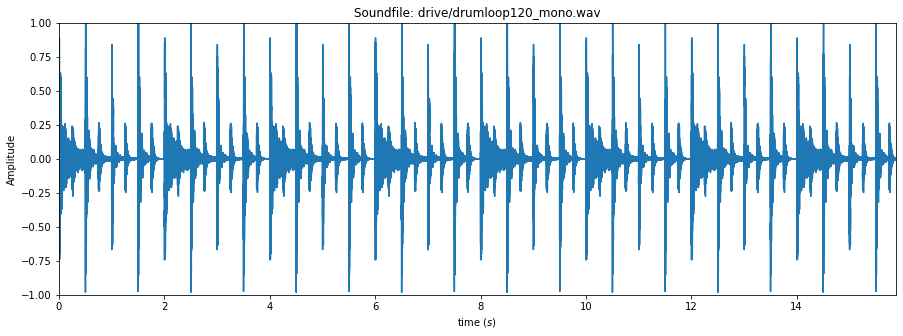

In [60]:
# Plotting the waveform

time_axis = np.arange(0, duration, 1/sample_rate)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(time_axis, samples)
ax.set_xlim((0,duration))
ax.set_ylim((-1,1))
ax.set_xlabel(r"time ($s$)")
ax.set_ylabel(r"Amplitude")
ax.set_title(f"Soundfile: {filepath}")

Text(0.5, 1.0, 'STFT LOG magnitude - Hopsize = 0.010s, duration Hann window = 0.030s')

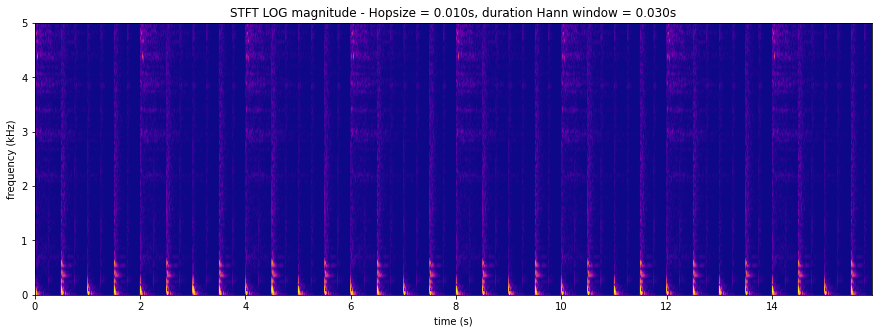

In [30]:
from scipy.signal import stft

window_size_in_samples = 0.030 * sample_rate
hop_size_in_samples    = 0.010 * sample_rate
noverlap = window_size_in_samples - hop_size_in_samples      # Number of points to overlap between segments

# Compute short-time Fourier transform
f, t, Zxx = stft(samples, fs=sample_rate, window='hann', nperseg=window_size_in_samples, noverlap=noverlap, nfft=8192)
f_kHz = f/1000  # conversion to kHz

# Logarithmic compression of the magnitude spectrum
gamma = 100
dB_mag_log_compr = np.log(1 + gamma * np.abs(Zxx))

#Plotting
fig, ax = plt.subplots(figsize=(15,5))                     
im = ax.pcolormesh(t, f_kHz, dB_mag_log_compr, shading='nearest', cmap='plasma')
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (kHz)')
ax.set_ylim((0,5))
ax.set_title(f'STFT LOG magnitude - Hopsize = 0.010s, duration Hann window = 0.030s')

Text(0.5, 1.0, 'Novelty function - Spectral flux - Hopsize = 0.010s, duration Hann window = 0.030s')

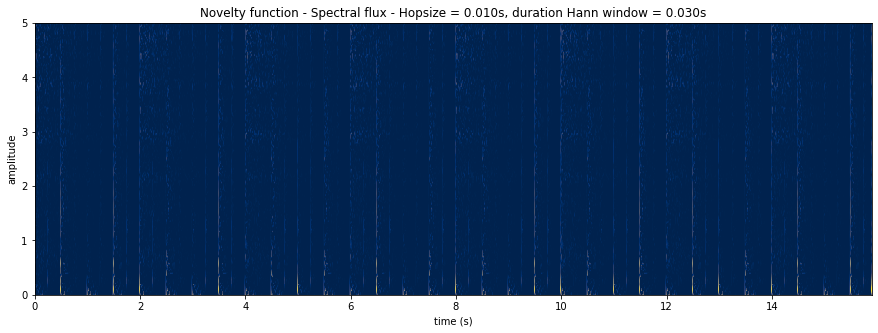

In [39]:
# Novelty function with half-wave rectification

novelty = np.roll(dB_mag_log_compr,-1, axis=1) - dB_mag_log_compr
noveltyHWR = (novelty + np.abs(novelty)) / 2

#Plotting
fig, ax = plt.subplots(figsize=(15,5))                     
im = ax.pcolormesh(t, f_kHz, noveltyHWR, shading='nearest', cmap='cividis')
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (kHz)')
ax.set_ylim((0,5))
ax.set_title(f'Novelty function - Spectral flux - Hopsize = 0.010s, duration Hann window = 0.030s')

Text(0.5, 1.0, 'Novelty function - Spectral flux - Hopsize = 0.010s, duration Hann window = 0.030s')

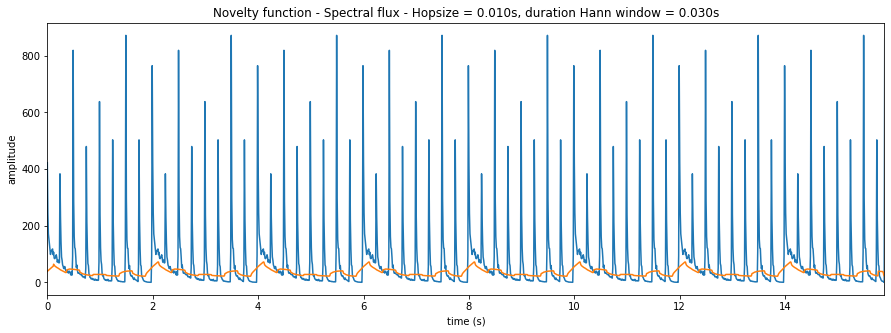

In [62]:
# Sum novelty over frequency onto time axis

noveltyHWR_time = np.sum(noveltyHWR, axis=0)

nr_samples = np.shape(noveltyHWR_time)[0]


"""
Check what value is the best:: for size averaging window

.
You would usually choose a value that is related to a time duration larger than the STFT window.
You need to take the average of a certain number of STFT windows at least. Experiment with values
of about 100ms up to a second, and see what happens!


.
.
.
.
.
"""

size_averaging_window = 25
moving_average = np.convolve(np.ones(size_averaging_window), noveltyHWR_time, 'same') / (2*size_averaging_window+1)

#Plotting
fig, ax = plt.subplots(figsize=(15,5))                     
ax.plot(t, noveltyHWR_time, '-')
ax.plot(t, moving_average, '-')
ax.set_xlabel('time (s)')
ax.set_xlim(0,duration)
ax.set_ylabel('amplitude')
ax.set_title(f'Novelty function - Spectral flux - Hopsize = 0.010s, duration Hann window = 0.030s')

In [49]:
nr_samples

(1590,)

## Part 2.2 Spectral-based novelty by madmom

Madmom is a python toolbox that does some state-of-the-art rhythm processing for you. The repository is here (along with some tutorials):

https://github.com/CPJKU/madmom

In order to get better novelty features, you can use the code in the following tutorial as starting point:

https://github.com/CPJKU/madmom_tutorials/blob/master/onset_detection.ipynb

You can **run this tutorial as an addition, if you want to understand more** about state-of-the-art signal processing.

In order to use madmom in colab, I have to install it as follows, and to restart the runtime...which means this is better done in a separate python notebook. In order to re-import all libraries and create all needed variables again this separate notebook should start as:



In [6]:
import librosa
import librosa.display
import os, sys
from scipy import signal
import pydub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import madmom
from scipy.ndimage.filters import maximum_filter
import IPython.display as ipd

# filename1 = 'cretansyrtos.wav'#put your file
# root_path = 'gdrive/My Drive/Teaching/DT2470/lab2/labdata/'#put your path

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

## Part 2.3 Compute a Fourier tempogram

We will use the above spectral-based novelty function as an input, to compute a tempogram. From this tempogram, we can get an estimate of the tempo of a piece.

Again, produce the figures that I show below. I use the drumloop again, but you can use more interesting music files as well, for instance I provided the "cretansyrtos.wav" as an example of some Cretan folk dance.

So, as a starting point, you need to compute the spectral novelty function (equation 6.8) for whatever sound you intend to use.

The Fourier tempogram then is nothing but the STFT magnitude of the novelty function, with the frequency values mapped to tempo values (equation 6.24). Below you see what I get for a window size of 8 seconds, and a hop size of 0.5 seconds: 

![](https://drive.google.com/uc?id=1vgbnAiJ_vlGeO44j_syyIlTy_Z6FyiHm)

The red line in the above plot is the tempo estimate that I get, when I look for the maximum of the tempogram in each column in a range from 100 to 200 bpm. Implement this tempo estimation, and report also what you obtain when you do not constrain it to a specific tempo range.

## Part 2.4 Beat Tracking

In this part you will use two beat trackers, which are available in python:



1.   The librosa beat tracker, which is the dynamic programming approach presented in the book. An example for how to run the librosa beat tracker: https://musicinformationretrieval.com/beat_tracking.html

2.   And the madmom beat tracker, which is using deep learning. 

Apply both beat trackers to audio examples having the following three characteristics:

1. stable tempo, strong onsets (for instance, the drum loop example) 
2. instable tempo, strong onsets (for instance, the cretansyrtos) 
3. weak energy onsets (for instance, a string quartet or a choir performance) 

Provide plots for the waveform with the beats overlaid (using vlines or stem). Also listen to the beat tracking results, which you can do with code that looks somewhat as follows:



In [0]:
import IPython.display as ipd
clicks = librosa.clicks(beat_times, sr=sr, length=len(x))
ipd.Audio(x + clicks, rate=sr)

For tracking with madmom, your code should look someshat as shown below. Note that in order to run madmom, I need to install it with the --force-install option, so it might be better to do that in a separate python notebook. A nice example that applies both librosa and madmom is here: https://www.analyticsvidhya.com/blog/2018/02/audio-beat-tracking-for-music-information-retrieval/

In [0]:
import madmom
proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
act = madmom.features.beats.RNNBeatProcessor()(os.path.join(root_path,filename1))
beat_times = proc(act)


Report what differences you observe (mainly by listening to the audio with the clicks for the beats) between the beat tracking outputs obtained from the two algorithms. Why do you think these differences emerge? (Given what you know from the book chapter and the from example on the analyticsvidhya website)

The plot of waveform and beats I get for the cretansyrtos example using librosa:

![](https://drive.google.com/uc?id=1l1YtJjrCHzaGUDEQ9O4UBafarf983CvW)

The plot of waveform and beats I get for the cretansyrtos example using madmom:

![](https://drive.google.com/uc?id=1L5LHO2EwgHgg8ypuj57gaj2j0eboCa5k)